# Prevendo as Tarifas de Corridas de Taxi com Deep Feedfoward Networks

Este trabalho tem como sua base o terceiro capítulo do livro [Neural Network Projects with Python](https://www.amazon.com.br/Neural-Network-Projects-Python-James/dp/1789138906). Neste capítulo o autor usa o James Loy mostra como usar a biblioteca [Keras](https://keras.io/) para criar Deep Feed Neural Network com intuito de prever as tarifas cobradas de corridas de taxi do famoso dataset [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data).

Neste notebook você podera encontrar algumas diferenças do encontrado no livro ou mesmo no [repósitorio](https://github.com/PacktPublishing/Neural-Network-Projects-with-Python/tree/master/Chapter03) do livro do autor, como por exemplo a parte de análise exploratória um pouco mais extensa, feature engineering e otimização da rede neural criada para resolver o problema de classificação do dataset.

In [1]:
# Manipulação de Dados
import numpy as np
import pandas as pd

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Data Mining
import pingouin as pg
from scipy import stats

# Pré-processamento e Deep Learning
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

# Métricas
from sklearn.metrics import mean_squared_error

# Configurando o estilo de gráfico utilizado
%matplotlib inline
plt.rcParams["figure.figsize"] = 20, 10
plt.style.use('fivethirtyeight')
sns.set_palette('gist_ncar')

# Ignorando os avisos
import warnings
warnings.filterwarnings('ignore')

# PEP-8
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Carregando o dataset
df = pd.read_csv('Data/NYC_taxi.csv', parse_dates=['pickup_datetime'], nrows=2000000)

<IPython.core.display.Javascript object>

In [3]:
# Checando as primeiras linhas do dataset
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


<IPython.core.display.Javascript object>

In [4]:
# Cheacando as informações sobre as colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   key                object             
 1   fare_amount        float64            
 2   pickup_datetime    datetime64[ns, UTC]
 3   pickup_longitude   float64            
 4   pickup_latitude    float64            
 5   dropoff_longitude  float64            
 6   dropoff_latitude   float64            
 7   passenger_count    int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 122.1+ MB


<IPython.core.display.Javascript object>

In [5]:
# Excluindo a variável "key"
df.drop('key', axis=1, inplace=True)

<IPython.core.display.Javascript object>

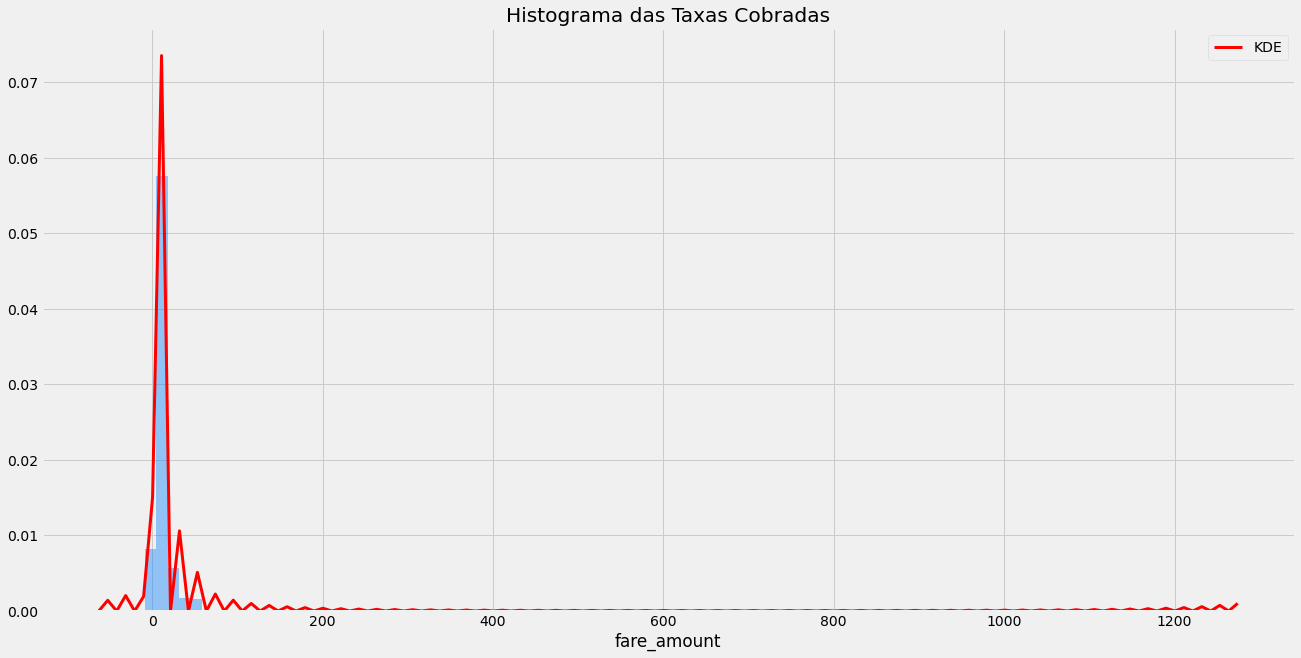

<IPython.core.display.Javascript object>

In [6]:
# Histograma e density plot para a variável 'fare_amount'
sns.distplot(df['fare_amount'],
             bins=100,
             hist=True, 
             kde_kws={'color':'r', 'lw':3, 'label':'KDE'})

# Plota o histograma
plt.title('Histograma das Taxas Cobradas')
plt.show()

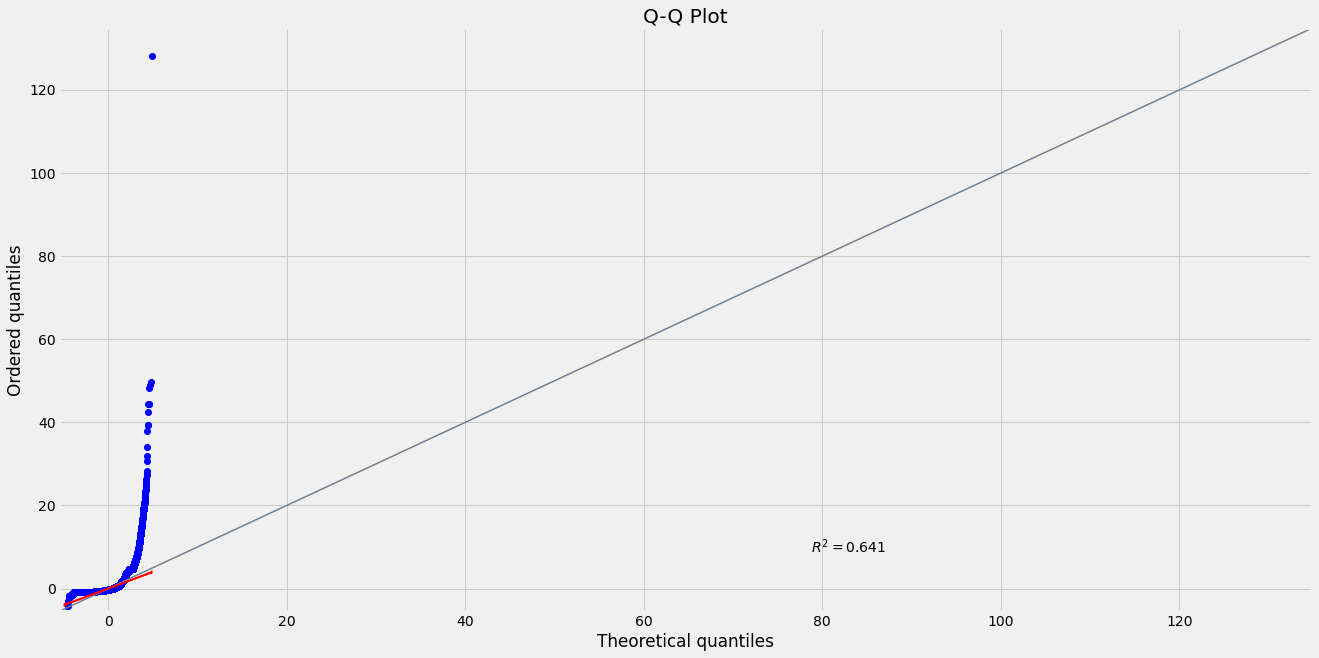

<IPython.core.display.Javascript object>

In [7]:
# Cria o gráfico
pg.qqplot(df['fare_amount'], 
          dist='norm', 
          figsize=(20, 10))

# Mostra o gráfico
plt.show()

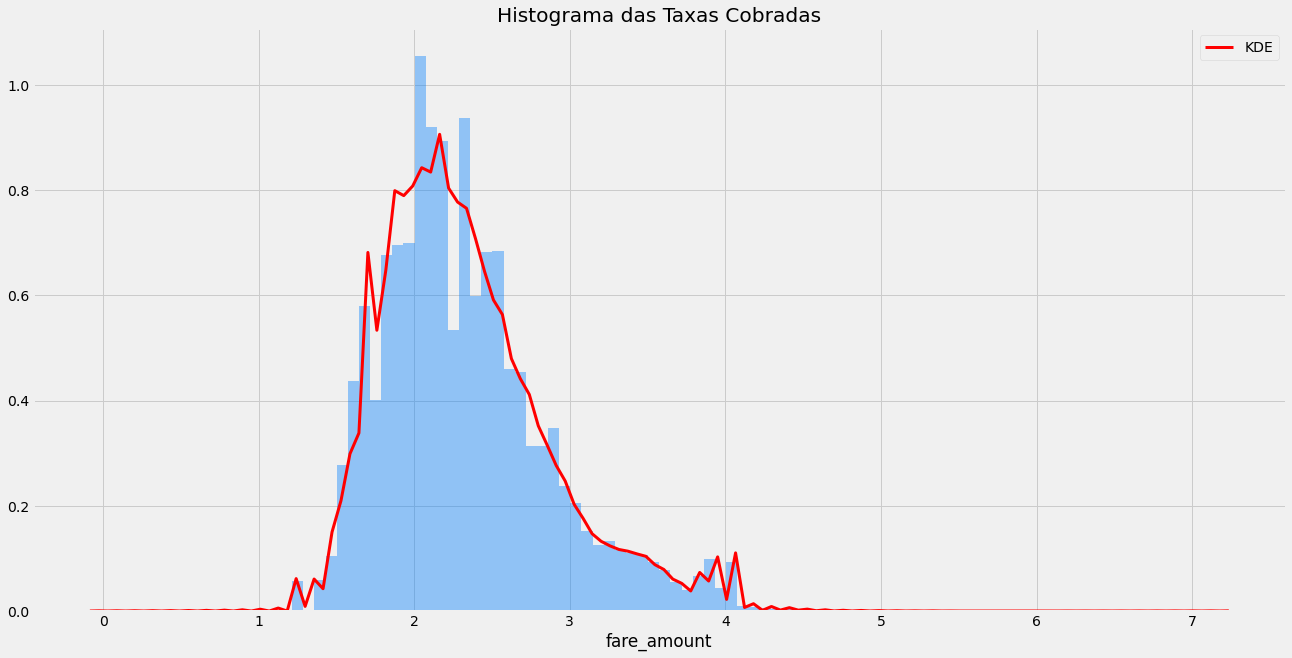

<IPython.core.display.Javascript object>

In [8]:
# Histograma e density plot para a variável 'fare_amount'
sns.distplot(np.log1p(df['fare_amount']),
             bins=100,
             hist=True, 
             kde_kws={'color':'r', 'lw':3, 'label':'KDE'})

# Plota o histograma
plt.title('Histograma das Taxas Cobradas')
plt.show()

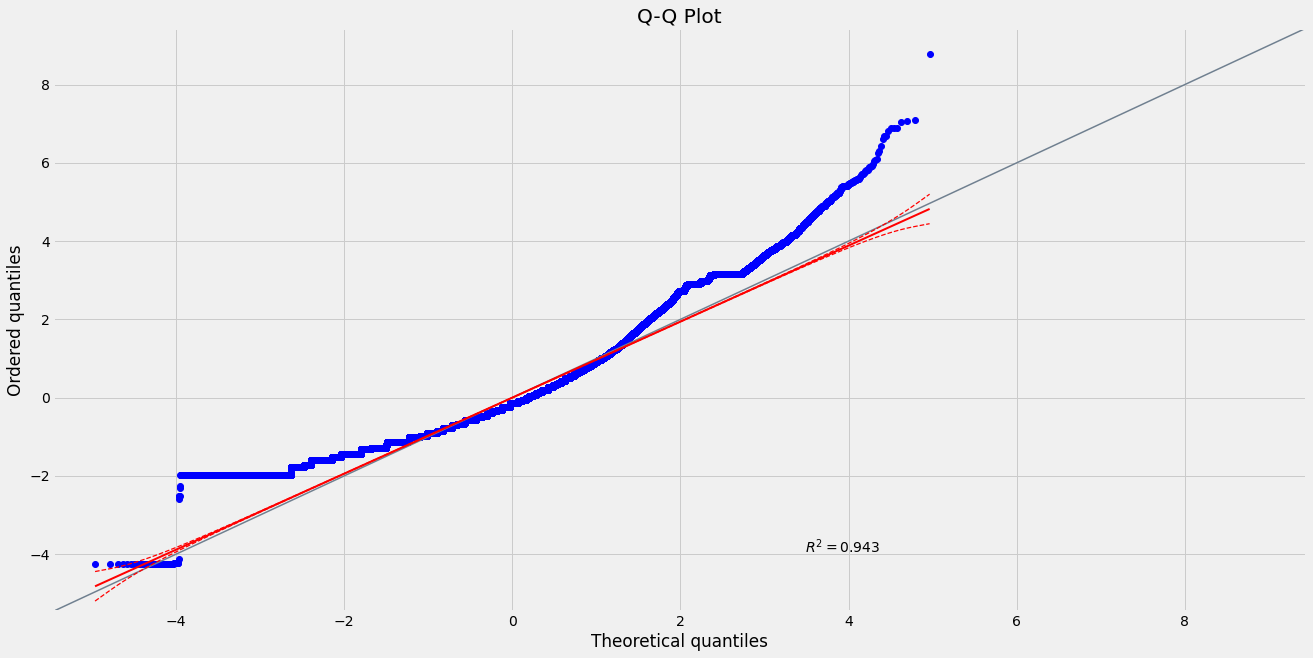

<IPython.core.display.Javascript object>

In [9]:
# Cria o gráfico
pg.qqplot(np.log1p(df['fare_amount']), 
          dist='norm', 
          figsize=(20, 10))

# Mostra o gráfico
plt.show()

In [10]:
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

<IPython.core.display.Javascript object>

In [11]:
def plot_hires(df, BB, ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1)

    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)

<IPython.core.display.Javascript object>

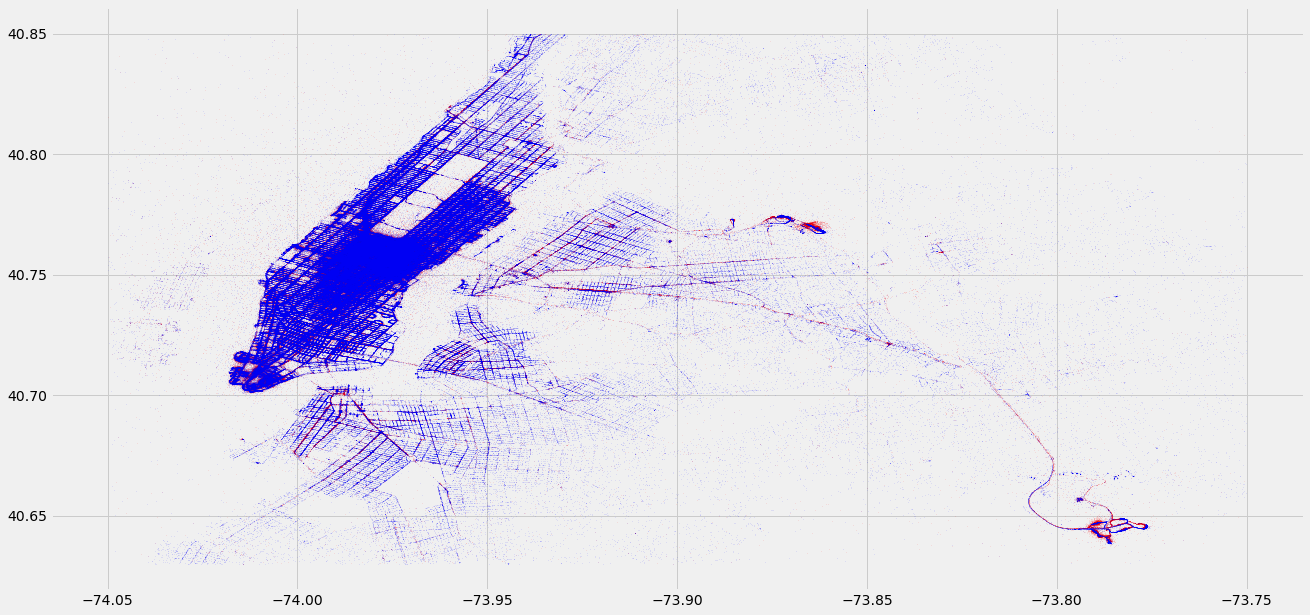

<IPython.core.display.Javascript object>

In [12]:
plot_hires(df, (-74.05, -73.75, 40.63, 40.85))

In [13]:
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

<IPython.core.display.Javascript object>

In [14]:
df.loc[:5,['pickup_datetime', 'year', 'month', 
           'day', 'day_of_week', 'hour']]

,pickup_datetime,year,month,day,day_of_week,hour
0,2009-06-15 17:26:21+00:00,2009,6,15,0,17
1,2010-01-05 16:52:16+00:00,2010,1,5,1,16
2,2011-08-18 00:35:00+00:00,2011,8,18,3,0
3,2012-04-21 04:30:42+00:00,2012,4,21,5,4
4,2010-03-09 07:51:00+00:00,2010,3,9,1,7
5,2011-01-06 09:50:45+00:00,2011,1,6,3,9


<IPython.core.display.Javascript object>

In [15]:
# Excluindo a coluna "pickup_datetime"
df.drop(['pickup_datetime'], axis=1, inplace=True)

<IPython.core.display.Javascript object>

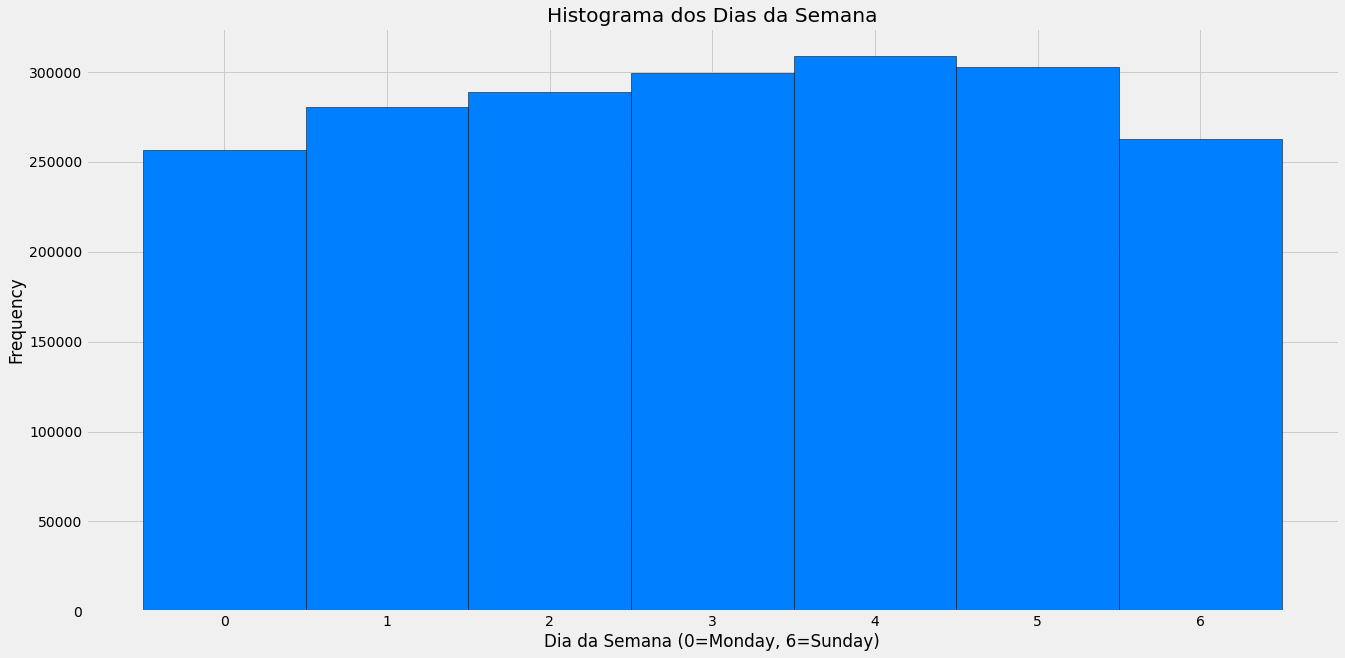

<IPython.core.display.Javascript object>

In [16]:
# Histograma e density plot para a variável 'fare_amount'
df['day_of_week'].plot.hist(bins=np.arange(8)-0.5, 
                            ec='black')

# Plota o histograma
plt.xlabel('Dia da Semana (0=Monday, 6=Sunday)')
plt.title('Histograma dos Dias da Semana')
plt.show()

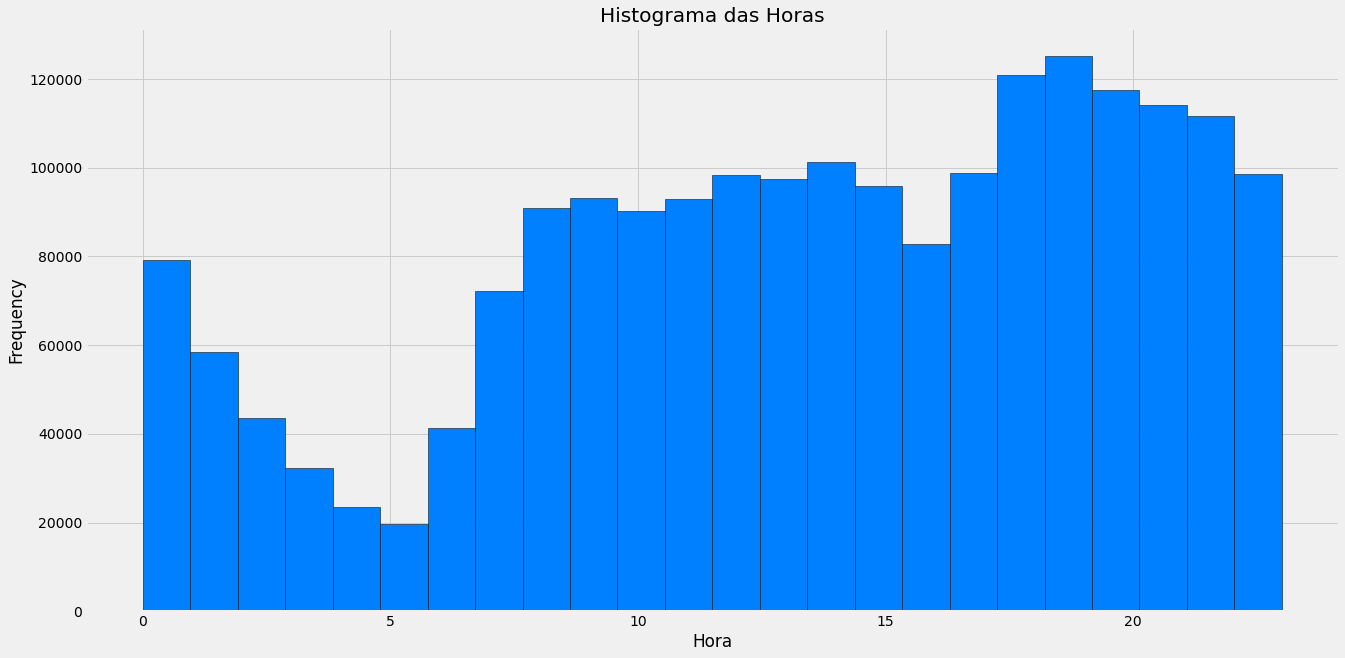

<IPython.core.display.Javascript object>

In [17]:
df['hour'].plot.hist(bins=24, ec='black')
plt.title('Histograma das Horas')
plt.xlabel('Hora')
plt.show()

In [18]:
# Checando valores nulos
df.isnull().sum()

fare_amount           0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
year                  0
month                 0
day                   0
day_of_week           0
hour                  0
dtype: int64

<IPython.core.display.Javascript object>

In [19]:
# Excluindo linhas com valores nulos
df.dropna(inplace=True)

<IPython.core.display.Javascript object>

In [20]:
# Resumo estatístico do dataset
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
count,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06,1.999986e+06
mean,1.134768e+01,-7.252324e+01,3.992965e+01,-7.252395e+01,3.992808e+01,1.684125e+00,2.011740e+03,6.267687e+00,1.571031e+01,3.041727e+00,1.350827e+01
std,9.852609e+00,1.286798e+01,7.983330e+00,1.277497e+01,1.032382e+01,1.314979e+00,1.860588e+00,3.436747e+00,8.681900e+00,1.949844e+00,6.515764e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00,2.009000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00,2.010000e+03,3.000000e+00,8.000000e+00,1.000000e+00,9.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00,2.012000e+03,6.000000e+00,1.600000e+01,3.000000e+00,1.400000e+01
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00,2.013000e+03,9.000000e+00,2.300000e+01,5.000000e+00,1.900000e+01
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02,2.015000e+03,1.200000e+01,3.100000e+01,6.000000e+00,2.300000e+01


<IPython.core.display.Javascript object>

In [21]:
# Removendo linhas com tarifas inferiores a US $ 0 e superiores a US $ 100
df = df[(df['fare_amount'] >= 0) & (df['fare_amount'] <= 100)]

<IPython.core.display.Javascript object>

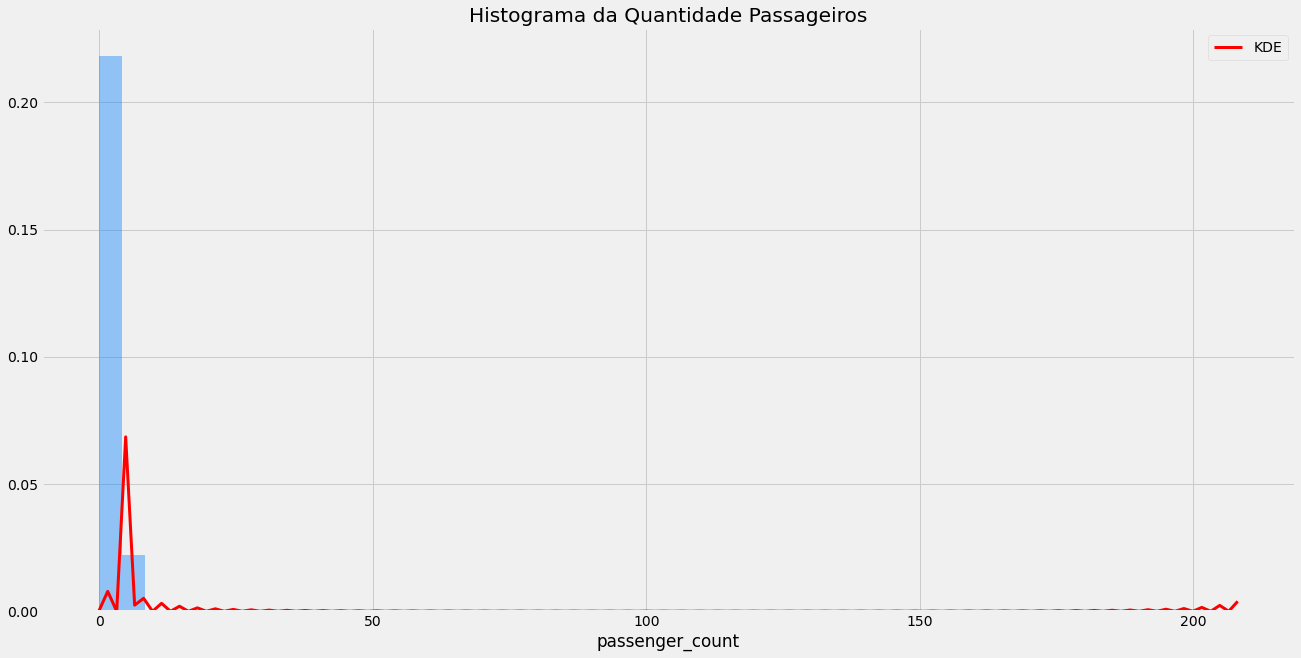

<IPython.core.display.Javascript object>

In [22]:
# Histograma e density plot para a variável 'fare_amount'
sns.distplot(df['passenger_count'],
             hist=True, 
             kde_kws={'color':'r', 'lw':3, 'label':'KDE'})

# Plota o histograma
plt.title('Histograma da Quantidade Passageiros')
plt.show()

In [23]:
# Removendo as corridas com valores iguais a zero
df.loc[df['passenger_count'] == 0, 'passenger_count'] = 1

<IPython.core.display.Javascript object>

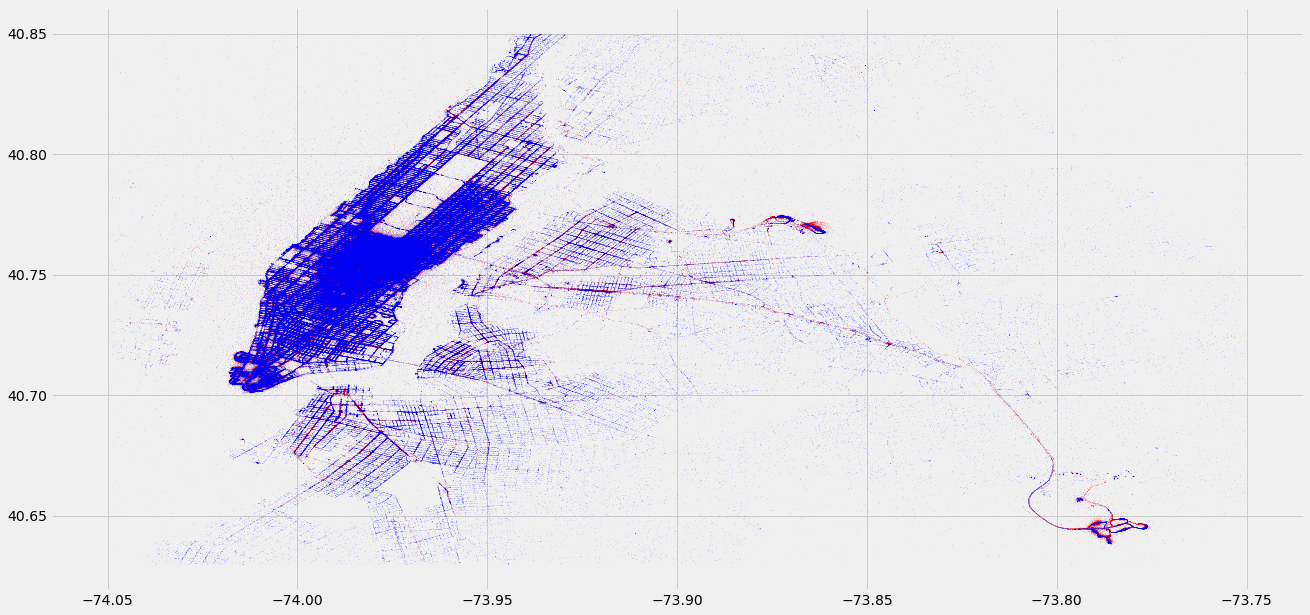

<IPython.core.display.Javascript object>

In [24]:
# Mapa depois da remoção dos outliers
plot_hires(df, (-74.05, -73.75, 40.63, 40.85))

In [25]:
# Range da longitude para NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# Range da latitude para NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

# Considere apenas locais dentro de Nova York
for long in ['pickup_longitude', 'dropoff_longitude']:
    df = df[(df[long] > nyc_min_longitude) & (df[long] < nyc_max_longitude)]

for lat in ['pickup_latitude', 'dropoff_latitude']:
    df = df[(df[lat] > nyc_min_latitude) & (df[lat] < nyc_max_latitude)]

<IPython.core.display.Javascript object>

In [26]:
df.loc[:5,['year', 'month', 'day', 'day_of_week', 'hour']]

,year,month,day,day_of_week,hour
0,2009,6,15,0,17
1,2010,1,5,1,16
2,2011,8,18,3,0
3,2012,4,21,5,4
4,2010,3,9,1,7
5,2011,1,6,3,9


<IPython.core.display.Javascript object>

In [27]:
def euc_distance(lat1, long1, lat2, long2):
    return (((lat1 - lat2)**2 + (long1 - long2)**2)**0.5)

<IPython.core.display.Javascript object>

In [28]:
df['distance'] = euc_distance(df['pickup_latitude'], 
                              df['pickup_longitude'], 
                              df['dropoff_latitude'],
                              df['dropoff_longitude'])

<IPython.core.display.Javascript object>

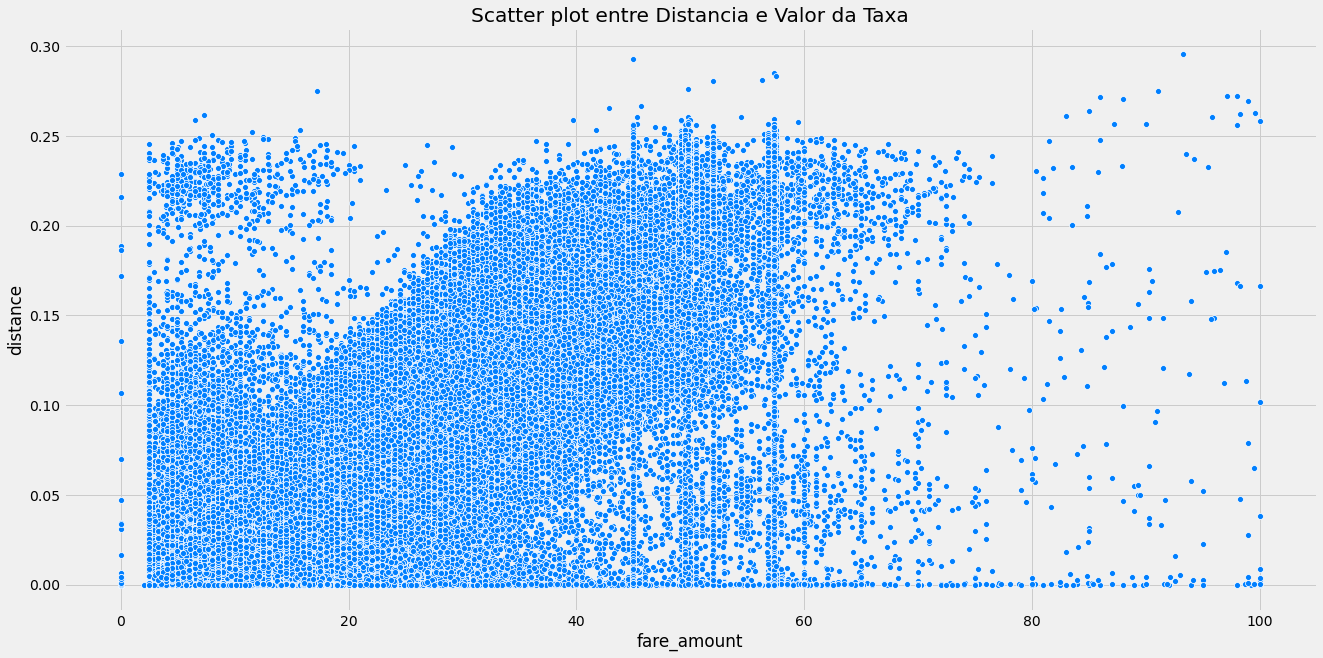

<IPython.core.display.Javascript object>

In [29]:
# Checando a relação entre distancia e a taxa cobrada
sns.scatterplot(x='fare_amount', 
                y='distance', 
                data=df)

# Plota o histograma
plt.title('Scatter plot entre Distancia e Valor da Taxa')
plt.show()

In [30]:
airports = {'JFK_Airport': (-73.78,40.643),
            'Laguardia_Airport': (-73.87, 40.77),
            'Newark_Airport' : (-74.18, 40.69)}

for airport in airports:
    df['pickup_dist_' + airport] = euc_distance(df['pickup_latitude'],
                                                df['pickup_longitude'], 
                                                airports[airport][1], 
                                                airports[airport][0])
    df['dropoff_dist_' + airport] = euc_distance(df['dropoff_latitude'], 
                                                 df['dropoff_longitude'],
                                                 airports[airport][1], 
                                                 airports[airport][0])

<IPython.core.display.Javascript object>

In [31]:
# Checando as transformações no dataset
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,distance,pickup_dist_JFK_Airport,dropoff_dist_JFK_Airport,pickup_dist_Laguardia_Airport,dropoff_dist_Laguardia_Airport,pickup_dist_Newark_Airport,dropoff_dist_Newark_Airport
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,0.009436,0.101340,0.092710,0.055043,0.064326,0.337147,0.339123
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,0.079696,0.245731,0.242961,0.157402,0.109925,0.165330,0.220812
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,0.013674,0.234714,0.237050,0.113076,0.122790,0.209742,0.198236
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,0.025340,0.225895,0.240846,0.122792,0.122149,0.197636,0.200358
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,0.019470,0.225847,0.225878,0.098115,0.087741,0.225807,0.242228


<IPython.core.display.Javascript object>

In [32]:
# Criando uma cópia do dataset
df_prescaled = df.copy()

<IPython.core.display.Javascript object>

In [33]:
# Excluindo a variável target
df_scaled = df.drop(['fare_amount'], axis=1)

# Colocando todas a features na mesma escala
df_scaled = scale(df_scaled)

# Colocando as features escaladas em conjunto com a variável alvo
cols = df.columns.tolist()
cols.remove('fare_amount')
df_scaled = pd.DataFrame(df_scaled, 
                         columns=cols, 
                         index=df.index)
df_scaled = pd.concat([df_scaled, df['fare_amount']], 
                      axis=1)
df = df_scaled.copy()

<IPython.core.display.Javascript object>

In [34]:
# Separa as variáveis preditoras da variável target
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

# Divide o conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<IPython.core.display.Javascript object>

In [35]:
# Criando a Deep Feedfoward Network

# Instancia o modelo
model = Sequential()

# Adiciona as camadas
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

# Mostra o sumário do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 13,313
Trainable params: 13,313
Non-trainable params: 0
____________________________________________________

<IPython.core.display.Javascript object>

In [36]:
# Compila e treina o modelo
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(X_train, y_train, epochs=1)

48354/48354 [==============================] - 112s 2ms/step - loss: 12.3497 - mse: 12.3497


<IPython.core.display.Javascript object>

In [37]:
# Verificando o RMSE de treino e teste
train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print('Train RMSE: ', np.round((train_rmse),2))
print('Test RMSE: ', np.round((test_rmse), 2))

Train RMSE:  3.45
Test RMSE:  3.41


<IPython.core.display.Javascript object>

In [38]:
# Função para prever o custo de uma corrida
def predict_random(df_prescaled, X_test, model):
    sample = X_test.sample(n=1, random_state=np.random.randint(low=0, high=10000))
    idx = sample.index[0]
    
    actual_fare = df_prescaled.loc[idx, 'fare_amount']
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_of_week = day_names[df_prescaled.loc[idx,'day_of_week']]
    hour = df_prescaled.loc[idx, 'hour']
    predicted_fare = model.predict(sample)[0][0]
    rmse = np.sqrt(np.square(predicted_fare - actual_fare))
    
    print("Trip Details: {}, {}:00hrs".format(day_of_week, hour))  
    print("Actual fare: ${:0.2f}".format(actual_fare))
    print("Predicted fare: ${:0.2f}".format(predicted_fare))
    print("RMSE: ${:0.2f}".format(rmse))

<IPython.core.display.Javascript object>

In [39]:
# Prevendo o preço de uma corrida aleatória
predict_random(df_prescaled, X_test, model)

Trip Details: Saturday, 23:00hrs
Actual fare: $10.10
Predicted fare: $9.19
RMSE: $0.91


<IPython.core.display.Javascript object>